<a id="top"></a>

# Processing WFC3/UVIS Data with `calwf3` Using the v1.0 CTE-Correction  
<hr>

## Learning Goals
This notebook explains how to calibrate `raw` WFC3/UVIS data with the v1.0 pixel-based CTE correction within `calwf3`. 

<br>

By the end of this tutorial, you will:

- Download a raw WFC3 image from MAST. 
- Find the necessary reference files needed for calibration.
- Edit header keywords.
- Run `calwf3` `v3.5.2` to calibrate the raw image with the v1.0 pixel based CTE-correction.
- Compare v1.0 and v2.0 products. 

## Table of Contents
 [Introduction](#intro)<br>
 
 [1. Imports](#imports) <br>
 [2. Verify `archived_drkcfiles.txt` is in CWD](#txtfile) <br>
 [3. Check that `calwf3` Version is `v3.5.2`](#checkcalver) <br>
 [4. Query MAST and Download a WFC3 `raw.fits` Image](#download) <br>
 [5. Set CRDS Environment Variable and Download Reference Files](#env_var) <br>
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1 Run `crds bestrefs`](#bestrefs) <br>
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2 Inspect Image Header](#imageheaders) <br>
 [6. Find the Correct v1.0 DRKCFILE](#finddark) <br>
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.1 Download the Correct DRKCFILE from CRDS](#sync_dkc) <br>
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.2 Modify the Image Header Keyword, `DRKCFILE`](#mod_dkc) <br>
 [7. Download the v1.0 PCTETAB](#sync_pctetab) <br>
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[7.1 Modify the Image Header Keyword `PCTETAB`](#mod_pcte) <br>
 [8. Re-Inspect Image Header](#reinspect) <br>
 [9. Run `calwf3`](#runcal) <br>
[10. Inspect `FLC` Image Header](#inspectflc) <br>
[11. Investigate v1.0 and v2.0 Differences](#verdiffs) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[11.1 Download the v2.0 FLC File](#downloadv2.0)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[11.2 Open Files](#openfiles) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[11.3 Display 50x50 Pixel Background Subsection](#bkgsub) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[11.3.1 Pixel Distribution of Background Subsections](#bkgdist) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[11.4 Display Image Subsection](#imgsub) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[11.5 Aperture Photometry](#apphot) <br>
[12. Conclusions](#conclude) <br>

[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) 

<a id="intro"></a>

## Introduction 

The v1.0 pixel-based Charge Transfer Efficiency (CTE) correction was first implemented into `calwf3` `v3.3` in 2016 <br> ([Ryan et al. 2016](https://ui.adsabs.harvard.edu/abs/2016wfc..rept....1R/abstract), [Anderson & Bedin 2010](https://ui.adsabs.harvard.edu/abs/2010PASP..122.1035A/abstract), [HSTCAL release notes](https://github.com/spacetelescope/hstcal/releases/tag/1.0.0)). This also marked the first time users could directly <br> download CTE-corrected `flc & drc` files from [MAST](https://mast.stsci.edu/search/hst/ui/#/).  While the v1.0 correction was sufficient  for many years, the <br> degradation of CTE over time reduced the efficacy of the model in treating low-level pixels. The v1.0 correction adversely <br> impacts (overcorrects) both the image background and faint sources. In April 2021 the v2.0 pixel-based CTE correction <br> was implemented in `calwf3` `v3.6.0` ([Anderson et al. 2021](https://ui.adsabs.harvard.edu/abs/2021wfc..rept....9A/abstract), [Kuhn & Anderson 2021](https://ui.adsabs.harvard.edu/abs/2021wfc..rept....6K/abstract),  [HSTCAL release notes](https://github.com/spacetelescope/hstcal/releases/tag/2.7.0)). Since <br> MAST uses the latest release of `calwf3` for calibration, any WFC3/UVIS CTE corrected data retrieved from MAST, <br> regardless of observation date, will be calibrated with the v2.0 pixel-based CTE correction. Although v1.0 pixel-based <br> CTE-corrected `flc & drc` files are no longer accessable through MAST, this notebook steps through the procedure <br> required to calibrate WFC3/UVIS images using the v1.0 CTE correction. <br>


One of the limiting factors of using the v1.0 CTE correction are the CTE corrected dark current reference files (`DRKCFILE`). <br> These dark reference files are delivered to MAST by the WFC3 team and use the same pixel-based CTE correction within <br> `calwf3`. Now that we have switched to the v2.0 CTE correction there is a cut off for dark current reference files that use <br> the v1.0 correction. Observations taken after February 2021 will not have CTE corrected dark files using the v1.0 algorithm, <br> which means **applying the v1.0 CTE correction works best for observations taken between May 2009 - February 2021.** <br> If the observation being calibrated was taken after February 2021 there are two options: **1)** use the last v1.0 CTE corrected <br> dark reference file from February 2021 or **2)** use the v2.0 CTE corrected dark with the most appropriate `USEAFTER` for the <br> science exposure's observation date. 

<a id="imports"></a>
## 1. Imports

<div class="alert alert-block alert-warning" style="color:black" > <b> This notebook assumes you have created and activated a virtual environment using the requirements file in this notebook's repository. Please make sure you have read the README file before continuing.</b> <br> </div>

We import: <br>

| Package Name                             | Purpose                                                |
|:-----------------------------------------|:-------------------------------------------------------|
| `glob`                                   | creating list of files                                 |
| `os`                                     | directory maintenance and setting environment variables|
| `astropy.io.fits`                        | opening and modifying fits files                       |
| `astroquery.mast.Observations`           | downloading data from MAST                             |
| `astropy.table.Table`                    | creating and manipulating data tables                  |
| `astropy.visualization.ZScaleInterval`   | finding z-scale limits when displaying images          |
| `matplotlib.pyplot`                      | plotting and displaying images                         |
| `numpy`                                  | finding indices and concatenating arrays               |
| `photutils.aperture.aperture_photometry` | performing aperture photometry                         |
| `photutils.aperture.CircularAperture`    | creating circular apertures                            |
| `photutils.aperture.CircularAnnulus`     | creating circular annuli                               |
| `wfc3tools.calwf3`                       | verifying the version and running pipeline             |
| `background_median.aperture_stats_tbl`   | measuring background values within annuli              |

In [1]:
import glob
import os

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Observations
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from wfc3tools import calwf3

from example.background_median import aperture_stats_tbl

<a id="txtfile"></a>
## 2. Verify `archived_drkcfiles.txt` is in CWD
When you cloned/downloaded this notebook from [hst_notebooks](https://github.com/spacetelescope/hst_notebooks/), a .txt file should have been included. The file name is <br> `archived_drkcfiles.txt` and it is used later on in the notebook. This .txt file includes the file name, delivery date, activation <br> date, and USEAFTER date for every v1.0 CTE corrected dark reference file between May 2009 - February 2021. Below, we will use <br> this file in conjunction with the observation date of the file(s) being calibrated to pick out the most appropriate v1.0 CTE corrected <br> dark reference file(s).<br>

Please make sure the `archived_drkcfiles.txt` file is in the current working directory before continuing.

In [2]:
# list cwd to verify txt file is there
!ls -l archived_drkcfiles.txt

-rw-r--r-- 1 runner runner 350644 Nov  3 18:25 archived_drkcfiles.txt


<a id="checkcalver"></a>
## 3. Check that `calwf3` Version is `v3.5.2`
In April 2021, a new `calwf3` version was released that contains the v2.0 CTE-correction. If you would like to use the v1.0 correction, <br> 
your current environment must be using `calwf3` versions equal to or between `3.3` - `3.5.2`. However, in order to get the best <br>
v1.0 calibrated images we must use `calwf3` `v3.5.2`. All `calwf3` versions are hosted in the [`hstcal` package](https://github.com/spacetelescope/hstcal), and `calwf3` <br>
`v3.5.2` is part of the `hstcal` release `v2.6.0`. This version of `calwf3` also includes the ([~Jan 2021](https://github.com/spacetelescope/hstcal/releases/tag/2.5.0)) update that added MJD <br>
as a parameterized variable for the `PHOTMODE` keyword, which enables a time-dependent photometric correction and zeropoint. <br>
<b>If your version of `calwf3` is `3.6.0` or higher, you must downgrade the `hstcal` package.</b> The safer option, however, is to <br>
create a new environment using the requirements file provided in the [notebook's repository](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/calwf3_v1.0_cte). 

<b>We recommend that you create an environment with the following commands in order to run this notebook properly</b>:<br>

* `$ conda create -n v1_PCTE -c conda-forge hstcal==2.6.0 python==3.11`
* `$ conda activate v1_PCTE`
* `$ pip install -r requirements.txt`
  
`hstcal` `v2.6.0` provides version `3.5.2` of `calwf3`, which is the last version that offers the v1.0 pixel-based CTE correction.


In [3]:
# print calwf3 version to make sure its equal to or between 3.3 and 3.5.2 
!calwf3.e --version

3.7.2


<a id="download"></a>
## 4. Query MAST and Download a WFC3 `raw.fits` Image 
Here, we download our image via `astroquery`. For more information, please look at the documentation for <br>
[Astroquery](https://astroquery.readthedocs.io/en/latest/),
[Astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html), and 
[CAOM Field Descriptions](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html), which is used for the `obs_table` variable below. <br>
Additionally, you may download the data from MAST using either the [HST MAST Search Engine](https://mast.stsci.edu/search/hst/ui/#/) or the more<br>
general [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html).

We download a `raw` image of star cluster 47 Tucanae (47Tuc, NGC 104), offset from the core, from CAL proposal [15576](https://www.stsci.edu/hst-program-info/program/?program=15576) (July 2019).<br>
After downloading the image, we move it to the current working directory (cwd).

In [4]:
# Edit this cell's first line if you would to download your own file(s)
# Get the observation records
obs_table = Observations.query_criteria(obs_id='idv404axq*', proposal_id=15576)

# Get the listing of data products
products = Observations.get_product_list(obs_table)

# Filter the products for the RAW files
filtered_products = Observations.filter_products(products, productSubGroupDescription='RAW')

# Download all the images above
download_table = Observations.download_products(filtered_products, mrp_only=False)

# For convenience move raws to cwd and remove empty download dir
for file in download_table['Local Path']:
    filename = file.split('/')[-1]
    os.rename(file, os.path.basename(file))
    os.rmdir('mastDownload/HST/'+filename[:9])
        
os.rmdir('mastDownload/HST/')
os.rmdir('mastDownload/')

 [Done]


In [5]:
# show list of current dir to verify fits file is there
!ls -l *raw.fits

-rw-r--r-- 1 runner runner 34891200 Nov  3 19:15 idv404axq_raw.fits


<a id="env_var"></a>
## 5. Set CRDS Environment Variable and Download Reference Files

<div class="alert alert-block alert-warning" style="color:black" > <b> If you already have the absolute paths set for CRDS, please skip the code cell immediately below and proceed to the crds bestrefs command in Section 5.1.</b> <br> </div>

Before we run `crds bestfefs` and `calwf3`, we need to [set environment variables](https://hst-crds.stsci.edu/docs/cmdline_bestrefs/) for several subsequent calibration tasks.  <br>
We will point to a subdirectory within the main `crds_cache/` using the `IREF` environment variable. The `IREF` variable is used <br>
for WFC3 reference files. Other instruments use other variables, e.g., `JREF` for ACS. You have the option to permanently add these <br>
environment variables to your user profile by adding the path in your shell's configuration file. If you're using bash, you would edit <br>
the `~/.bash_profile` file with lines such as:

* `export CRDS_SERVER_URL="https://hst-crds.stsci.edu"`
* `export CRDS_SERVER="https://hst-crds.stsci.edu"`
* `export CRDS_PATH="$HOME/crds_cache"`
* `export iref="${CRDS_PATH}/references/hst/wfc3/"`

In [6]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = 'crds_cache'
os.environ['iref'] = 'crds_cache/references/hst/wfc3/'

<a id="bestrefs"></a>
## 5.1 Run `crds bestrefs` 

The cell below calls [CRDS bestref](https://hst-crds.stsci.edu/static/users_guide/basic_use.html), which will copy the necessary reference files from CRDS over to your local machine, if you do not <br>
already have them. Without running this command we would not be able to calibrate the image with `calwf3`.

In [7]:
!crds bestrefs --update-bestrefs --sync-references=1 --files idv404axq_raw.fits

CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing idv404axq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


<a id="imageheaders"></a>
## 5.2 Inspect Image Header
When processing a raw file through `calwf3` ,  the pipeline uses a few different header keywords to initiate and run the <br>
pixel-based CTE correction. Here, we inspect the important header keywords from the raw file just downloaded.<br>
At this step, you should see: <br>
- `pctetab` set to `iref$54l1347ei_cte.fits`<br>
- `drkcfile` set to `iref$54n2022fi_dkc.fits`<br>
- `pctecorr` set to `PERFORM`.


In [8]:
# Collect header keyword info from raw file
file, date, expstart, pctetab, drkcfile, pctecorr = [], [], [], [], [], []
for f in glob.glob('*raw.fits'):
    h = fits.getheader(f)
    file.append(h['filename'])
    date.append(h['date-obs'])
    expstart.append(h['expstart'])
    pctetab.append(h['pctetab'])
    drkcfile.append(h['drkcfile'])
    pctecorr.append(h['pctecorr'])

image_table = Table([file, date, expstart, pctetab, drkcfile, pctecorr],
                    names=('file', 'date-obs', 'expstart', 'pctetab', 'drkcfile', 'pctecorr'))
image_table['expstart'].format = '5.6f'

# Sort and display the table
image_table.sort('expstart')
image_table

file,date-obs,expstart,pctetab,drkcfile,pctecorr
str18,str10,float64,str23,str23,str7
idv404axq_raw.fits,2019-07-29,58693.181643,iref$54l1347ei_cte.fits,iref$7bg1930ki_dkc.fits,PERFORM


<a id="finddark"></a>
## 6. Find the Correct v1.0 `DRKCFILE` 
Below, we open the .txt file containing a list of all the `DRKCFILE` reference files created with the v1.0 pixel-based CTE correction. <br>`DRKCFILE` reference files are CTE corrected files used by the pipeline to perform the dark current subtraction during the generation <br> of the `flc` file. The `DRKCFILE` files listed in `archived_drkcfiles.txt` have been archived on the CRDS database and while <br> they are still accessible for use and download, they are not being actively used by MAST. <br>

In the first cell, we generate an `astropy.Table` ( `drkc_table` ) using the data from the file `archived_drkcfiles.txt`,<br>
mentioned in [Section 2](#txtfile), and create empty lists for the final table. Then, in the second cell, we index the `drkc_table` table for the <br>
best `DRKCFILE` that corresponds to the `DATE-OBS`  of the `raw` file being calibrated. Lastly, in the third cell, we create and display<br>
the final `astropy.table` that contains just the necessary `DRKCFILE`.



In [9]:
# Generate astropy table from `archived_drkcfiles.txt`
drkc_table = Table.read('archived_drkcfiles.txt', format='ascii.commented_header')

# Create empty lists for final astropy table
rawfiles, obsdates, dkcfiles, uafters, active_dates = [], [], [], [], []

In [10]:
# Using image header table from section 4.1 find closest drkcfile
for expstart in image_table['expstart']:
    table_idx = np.where(abs(drkc_table['useafter-mjd']-expstart) == abs(drkc_table['useafter-mjd']-expstart).min())[0][0]

    rawfile = image_table[image_table['expstart'] == expstart]['file'][0]
    
    # if drkcfile has useafter date > rawfile expstart use previous drkcfile
    if drkc_table[table_idx]['useafter-mjd'] > image_table[image_table['file'] == rawfile]['expstart'][0]:
        table_idx -= 1
    # append info
    rawfiles.append(rawfile)
    obsdates.append(image_table[image_table['file'] == rawfile]['date-obs'][0])
    dkcfiles.append(drkc_table[table_idx]['drkcfile'])
    uafters.append(drkc_table[table_idx]['useafter'])
    active_dates.append(drkc_table[table_idx]['activation-date'])

In [11]:
# Generate table of filename, date-obs, drkc-filename, corresponding useafter
raw_dkc_tab = Table([rawfiles, obsdates, dkcfiles, uafters, active_dates],
                    names=('filename', 'date-obs', 'dkc-filename', 'dkc-useafter', 'dkc-activation'))
# Display table
raw_dkc_tab

filename,date-obs,dkc-filename,dkc-useafter,dkc-activation
str18,str10,str18,str10,str10
idv404axq_raw.fits,2019-07-29,3961719li_dkc.fits,2019-07-28,2019-09-09


<a id="sync_dkc"></a>
## 6.1 Download the Correct `DRKCFILE` from CRDS
Now that we know the name of the correct `DRKCFILE`, it must be retrieved from CRDS and stored on your local machine so that it<br>
can be used during calibration. To copy the file from CRDS we use the [crds sync](https://hst-crds.stsci.edu/static/users_guide/command_line_tools.html#crds-sync) command. 

In [12]:
for dkc in raw_dkc_tab['dkc-filename']:
    !crds sync --hst --files {dkc} --output-dir {os.environ['iref']}

CRDS - INFO -  Symbolic context 'hst-latest' resolves to 'hst_1294.pmap'
CRDS - INFO -  Reorganizing 27 references from 'flat' to 'flat'
CRDS - INFO -  Syncing explicitly listed files.
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  3 infos


<a id="mod_dkc"></a>
## 6.2 Modify the Image Header Keyword, `DRKCFILE`
With the v1.0 CTE-corrected dark current reference file that corresponds to our `raw` science file copied to our local machine, <br>
we're ready to edit the header keyword with the proper `DRKCFILE`. 

In [13]:
for file in glob.glob('i*raw.fits'):
    # Using raw_dkc_tab from above, grab appropriate drkcfile
    ctecorr_dark = 'iref$'+raw_dkc_tab[raw_dkc_tab['filename'] == file]['dkc-filename'][0]
    fits.setval(file, 'DRKCFILE', value=ctecorr_dark)

<a id="sync_pctetab"></a>
## 7. Download the v1.0 `PCTETAB`

The next reference file we're going to download from CRDS is the `PCTETAB`. This is the pixel-based correction reference table <br>
and without it the algorithm will not work. In order to use the v1.0 pixel based correction, we must retrieve the v1.0 `PCTETAB` <br>
and set the header keyword to the proper reference file. In the cells below, we use the `crds sync` command again and then <br> 
set the `raw` file's `PCTETAB` to the v1.0 reference table, [zcv2057mi_cte.fits](https://hst-crds.stsci.edu/browse/zcv2057mi_cte.fits).


In [14]:
!crds sync --hst --files zcv2057mi_cte.fits --output-dir {os.environ['iref']}

CRDS - INFO -  Symbolic context 'hst-latest' resolves to 'hst_1294.pmap'
CRDS - INFO -  Reorganizing 27 references from 'flat' to 'flat'
CRDS - INFO -  Syncing explicitly listed files.
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  3 infos


<a id="mod_pcte"></a>
## 7.1 Modify the Image Header Keyword, `PCTETAB`

In [15]:
fits.setval('idv404axq_raw.fits', 'PCTETAB', value='iref$zcv2057mi_cte.fits') 

<a id="reinspect"></a>
## 8. Re-Inspect Image Header 
Now with the headers modified, we inspect the keywords one last time to verify the file was updated properly before we process <br> it through `calwf3`. At this point you should see:<br> 
- `PCTETAB` set to `iref$zcv2057mi_cte.fits`<br>
- `DRKCFILE` set to `iref$3961719li_dkc.fits`<br>

In [16]:
# Recollect and display header keywords
file, date, expstart, pctetab, drkcfile, pctecorr = [], [], [], [], [], []
for f in glob.glob('*raw.fits'):
    h = fits.getheader(f)
    file.append(h['filename'])
    date.append(h['date-obs'])
    expstart.append(h['expstart'])
    pctetab.append(h['pctetab'])
    drkcfile.append(h['drkcfile'])
    pctecorr.append(h['pctecorr'])

updated_table = Table([file, date, expstart, pctetab, drkcfile, pctecorr],
                      names=('file', 'date-obs', 'expstart', 'pctetab', 'drkcfile', 'pctecorr'))
updated_table['expstart'].format = '5.6f'

# Sort and display the table
updated_table.sort('expstart')
updated_table

file,date-obs,expstart,pctetab,drkcfile,pctecorr
str18,str10,float64,str23,str23,str7
idv404axq_raw.fits,2019-07-29,58693.181643,iref$zcv2057mi_cte.fits,iref$3961719li_dkc.fits,PERFORM


<a id="runcal"></a>
## 9. Run `calwf3` 
As a reminder, the `calwf3` version must be `3.5.2` to use the v1.0 pixel-base CTE correction with the most up-to-date <br>
calibration parameters. If you are not using version `3.5.2` the below `calwf3` call will crash due to an out-of-date <br>
`IMPHTTAB` reference file.

In [17]:
if not os.path.exists('idv404axq_flt.fits'):
    calwf3('idv404axq_raw.fits')

In [18]:
# show list of cwd to verify calibrated files were made
!ls -ltr *.fits

-rw-r--r-- 1 runner runner 168079680 Nov  3 19:12 idv404axq_flt.fits
-rw-r--r-- 1 runner runner 168079680 Nov  3 19:12 idv404axq_flc.fits
-rw-r--r-- 1 runner runner 168802560 Nov  3 19:15 idv404axq_v2.0_flc.fits
-rw-r--r-- 1 runner runner  34891200 Nov  3 19:16 idv404axq_raw.fits


<a id="inspectflc"></a>
## 10. Inspect FLC Image Header
To verify that the data was calibrated with the v1.0 pixel-based CTE-correction, header keyword `CAL_VER` should be `3.5.2`,<br> `CTE_VER` should be `1.0`, and `CTE_NAME` should be `pixelCTE 2012`

In [19]:
# Recollect and display FLC header keywords
file, pctetab, drkcfile, pctecorr, calver, ctename, ctever = [], [], [], [], [], [], []
for f in glob.glob('*flc.fits'):
    h = fits.getheader(f)
    file.append(h['filename'])
    pctetab.append(h['pctetab'])
    drkcfile.append(h['drkcfile'])
    pctecorr.append(h['pctecorr'])
    calver.append(h['cal_ver'])
    ctename.append(h['cte_name'])
    ctever.append(h['cte_ver'])

final_table = Table([file, pctetab, drkcfile, pctecorr, calver, ctename, ctever],
                    names=('file', 'pctetab', 'drkcfile', 'pctecorr', 'cal_ver', 'cte_name', 'cte_ver'))

final_table

file,pctetab,drkcfile,pctecorr,cal_ver,cte_name,cte_ver
str18,str23,str23,str8,str19,str13,str3
idv404axq_flc.fits,iref$zcv2057mi_cte.fits,iref$3961719li_dkc.fits,COMPLETE,3.7.2 (Apr-15-2024),pixelCTE 2012,1.0
idv404axq_flc.fits,iref$54l1347ei_cte.fits,iref$7bg1930ki_dkc.fits,COMPLETE,3.7.2 (Apr-15-2024),pixelCTE 2019,2.0


<a id="verdiffs"></a>
## 11. Investigate v1.0 and v2.0 Differences 
Now that we have created a v1.0 CTE corrected image, lets compare it to the same image calibrated with the v2.0 correction.<br> 

<a id="downloadv2.0"></a>
## 11.1 Download the v2.0 FLC File
First, we need to download the same FLC file from MAST that is corrected with the v2.0 pixel-based CTE correction so that we can <br> compare it to the v1.0 FLC file we just created in the notebook. In this step we rename the downloaded FLC to `idv404axq_v2.0_flc.fits`.

In [20]:
# Get the observation records
obs_table = Observations.query_criteria(obs_id='idv404axq*', proposal_id=15576)

# Get the listing of data products
products = Observations.get_product_list(obs_table)

# Filter the products for the RAW files
filtered_products = Observations.filter_products(products, productSubGroupDescription='FLC', project='CALWF3')

# Download all the images above
download_table = Observations.download_products(filtered_products, mrp_only=False)

# For convenience move raws to cwd and remove empty download dir
for file in download_table['Local Path']:
    filename = file.split('/')[-1][:9]+'_v2.0_flc.fits'
    os.rename(file, os.path.basename(filename))
    os.rmdir('mastDownload/HST/'+filename[:9])
        
os.rmdir('mastDownload/HST/')
os.rmdir('mastDownload/')

 [Done]


<a id="openfiles"></a>
## 11.2 Open Files 
In the cell below, we open each of the different files (FLT, v1.0 and v2.0 FLC) and create full-frame ~4Kx4K arrays. Additionally, <br> we multiply the science arrays by the [pixel area maps](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/pixel-area-maps). Due to the geometric distortion  present in WFC3 images, these pixel <br> area maps are necessary to achieve uniformity in the measured counts of an object across the field. The pixel map simply <br> reflects the area of the pixels at the location of the source, and by multiplying the images by this field-dependent correction <br> factor, we will improve the accuracy of the photometry.    

In [21]:
# Open data and set variables
with fits.open('idv404axq_v2.0_flc.fits') as hdu:
    v2_uvis1 = hdu[4].data
    v2_uvis2 = hdu[1].data
with fits.open('idv404axq_flc.fits') as hdu:
    v1_uvis1 = hdu[4].data
    v1_uvis2 = hdu[1].data 
with fits.open('idv404axq_flt.fits') as hdu:
    flt_uvis1 = hdu[4].data
    flt_uvis2 = hdu[1].data 
    
# Load pixel area maps 
PAM_uvis1 = fits.getdata('example/UVIS1wfc3_map.fits')
PAM_uvis2 = fits.getdata('example/UVIS2wfc3_map.fits')

# Stich UVIS1 and 2 together and multiply by pixel area map
v2sci = np.concatenate([v2_uvis2*PAM_uvis2, v2_uvis1*PAM_uvis1])
v1sci = np.concatenate([v1_uvis2*PAM_uvis2, v1_uvis1*PAM_uvis1])
fltsci = np.concatenate([flt_uvis2*PAM_uvis2, flt_uvis1*PAM_uvis1])

<a id="bkgsub"></a>
## 11.3 Display 50x50 Pixel Background Subsection
One of the differences between the v1.0 and v2.0 CTE correction is the background level. Here, we show a square 50x50 pixel <br> subsection that is mostly featureless, i.e. no known sources or cosmic ray hits. The v2.0 correction significantly reduces noise <br> amplification and improves the resulting background. To aid in the visual inspection of the background subsection, an animated <br> GIF is included in the notebook that blinks between the v1.0 and v2.0 FLC files. 

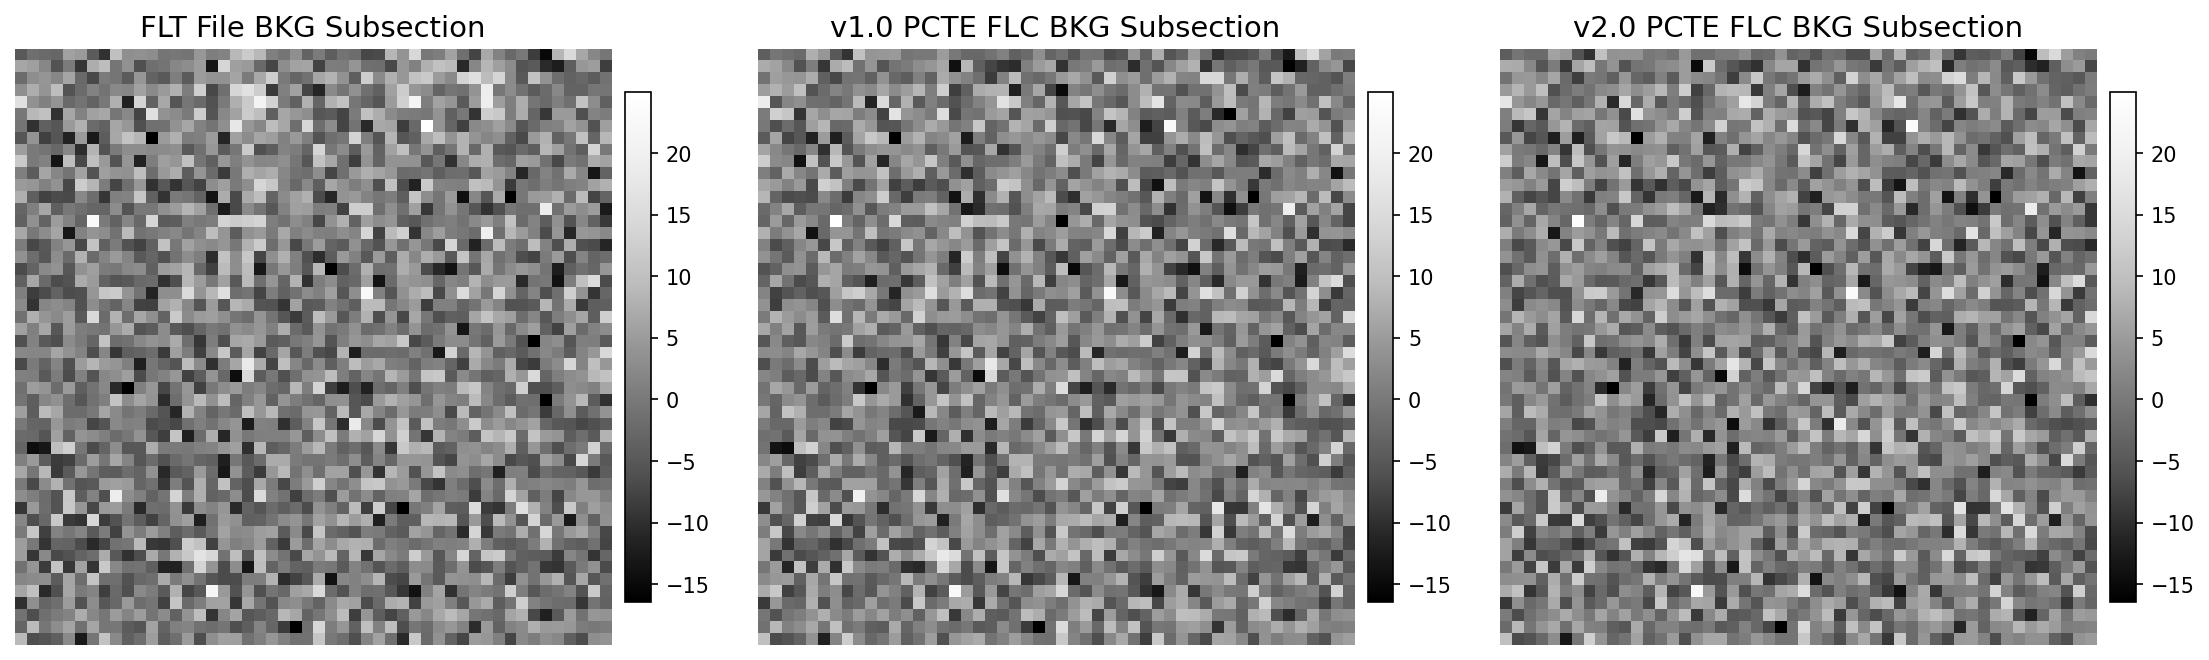

In [22]:
# Generate subplots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 10), dpi=150)

# Generate background subsections
flt_bkg = fltsci[2070:2120, 2180:2230]
v1_bkg = v1sci[2070:2120, 2180:2230]
v2_bkg = v2sci[2070:2120, 2180:2230]

# Calculate min and max values for image scaling 
z = ZScaleInterval()
z1, z2 = z.get_limits(v1_bkg)

# Display background subsection
im1 = ax1.imshow(flt_bkg, origin='lower', cmap='Greys_r', vmin=z1, vmax=z2)
im2 = ax2.imshow(v1_bkg, origin='lower', cmap='Greys_r', vmin=z1, vmax=z2)
im3 = ax3.imshow(v2_bkg, origin='lower', cmap='Greys_r', vmin=z1, vmax=z2)

# Formatting
fig.colorbar(im1, ax=ax1, shrink=0.35, pad=0.02)
fig.colorbar(im2, ax=ax2, shrink=0.35, pad=0.02)
fig.colorbar(im3, ax=ax3, shrink=0.35, pad=0.02)
ax1.set_title('FLT File BKG Subsection', size=14)
ax2.set_title('v1.0 PCTE FLC BKG Subsection', size=14)
ax3.set_title('v2.0 PCTE FLC BKG Subsection', size=14)
ax1.axis('off'), ax2.axis('off'), ax3.axis('off')
fig.tight_layout()

<div style="text-align: left"> <strong> <font size ="4">Animated GIF of the v1.0 and v2.0 FLC image subsections: </font> </strong> </div>

<img align="left" width="800" height="800" src="example/v1_v2_bkg.gif" alt="An animated gif blinking between a subsection of background sky using the v1.0 and V2.0 pixel-based CTE corrections. The v2.0 background appears smoother with less noise and pixel variations.">


<a id="bkgdist"></a>
## 11.3.1 Pixel Distribution of Background Subsections
To gain a more quantitative picture of how the background pixels are changing between the different file versions, we plot <br>the distribution of pixel values from the 50x50 pixel subsection above. The increased noise level in the v1.0 correction is <br> apparent in the blue histogram below. In addition, we have also computed the difference between the file types and have <br> plotted them as histograms. These two plots illustrates how the background in the v2.0 CTE corrected image is less noisy <br> and more in-line with the values seen in the FLT image.    

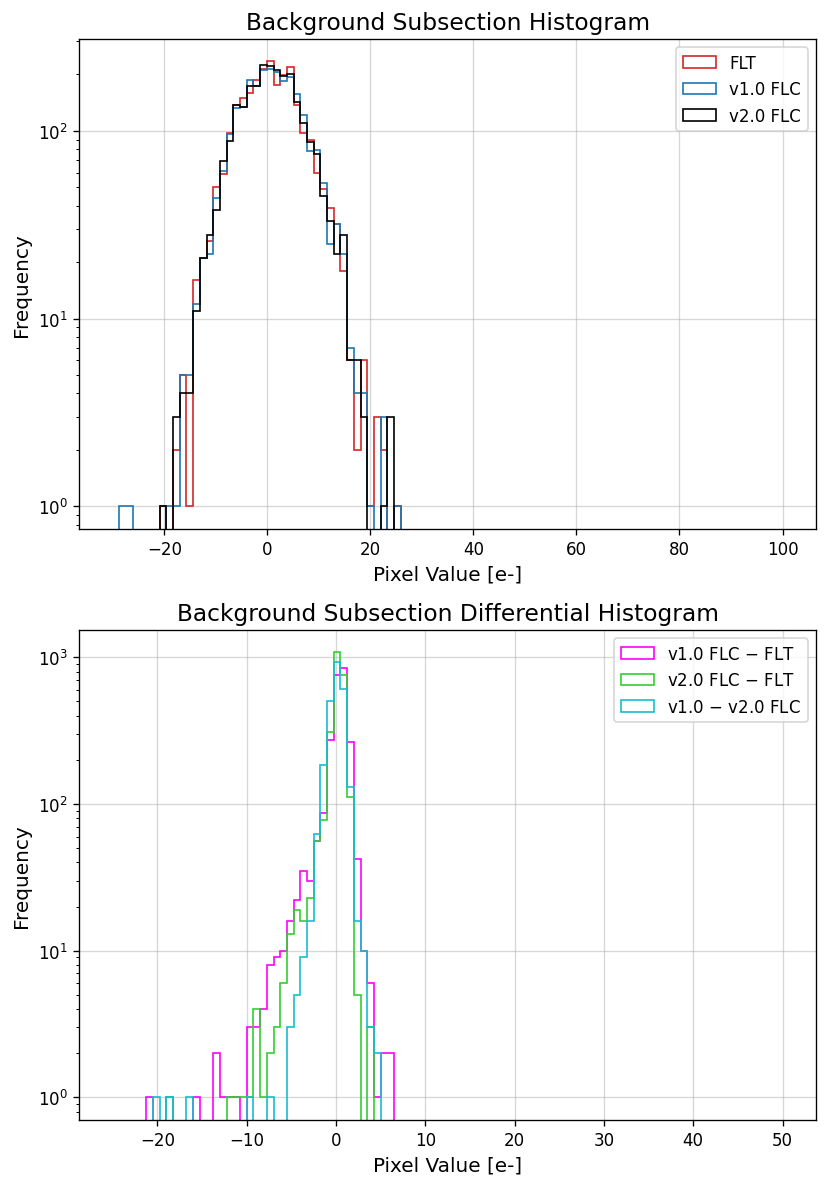

In [23]:
# Generate subplots
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(7, 10), dpi=120)

# Plot background subsection histograms
ax1.hist(flt_bkg.ravel(), bins=100, range=(-30, 100), histtype='step', color='C3', label='FLT')
ax1.hist(v1_bkg.ravel(), bins=100, range=(-30, 100), histtype='step', color='C0', label='v1.0 FLC')
ax1.hist(v2_bkg.ravel(), bins=100, range=(-30, 100), histtype='step', color='k', label='v2.0 FLC')

# Plot background subsection differential histograms
ax2.hist((v1_bkg-flt_bkg).ravel(), bins=100, range=(-25, 50), histtype='step', color='magenta', label='v1.0 FLC $-$ FLT')
ax2.hist((v2_bkg-flt_bkg).ravel(), bins=100, range=(-25, 50), histtype='step', color='limegreen', label='v2.0 FLC $-$ FLT')
ax2.hist((v1_bkg-v2_bkg).ravel(), bins=100, range=(-25, 50), histtype='step', color='C9', label='v1.0 $-$ v2.0 FLC')

# Formatting
ax1.set_title('Background Subsection Histogram', size=14)
ax2.set_title('Background Subsection Differential Histogram', size=14)
ax1.set_xlabel('Pixel Value [e-]', size=12)
ax1.set_ylabel('Frequency', size=12)
ax2.set_xlabel('Pixel Value [e-]', size=12)
ax2.set_ylabel('Frequency', size=12)
ax1.grid(alpha=0.5), ax2.grid(alpha=0.5)
ax1.legend(), ax2.legend()
ax1.set_yscale('log')
ax2.set_yscale('log')
fig.tight_layout()

<a id="imgsub"></a>
## 11.4 Display Image Subsection
Another difference between the v1.0 and v2.0 pixel-based CTE model is the amount of correction applied to fainter sources. <br> In order to reduce noise amplification, the fluxes of faint sources only receive a limited amount of correction in the v2.0 version. <br> We again provide an animated GIF of the two subsections to aid with the visual comparison. 

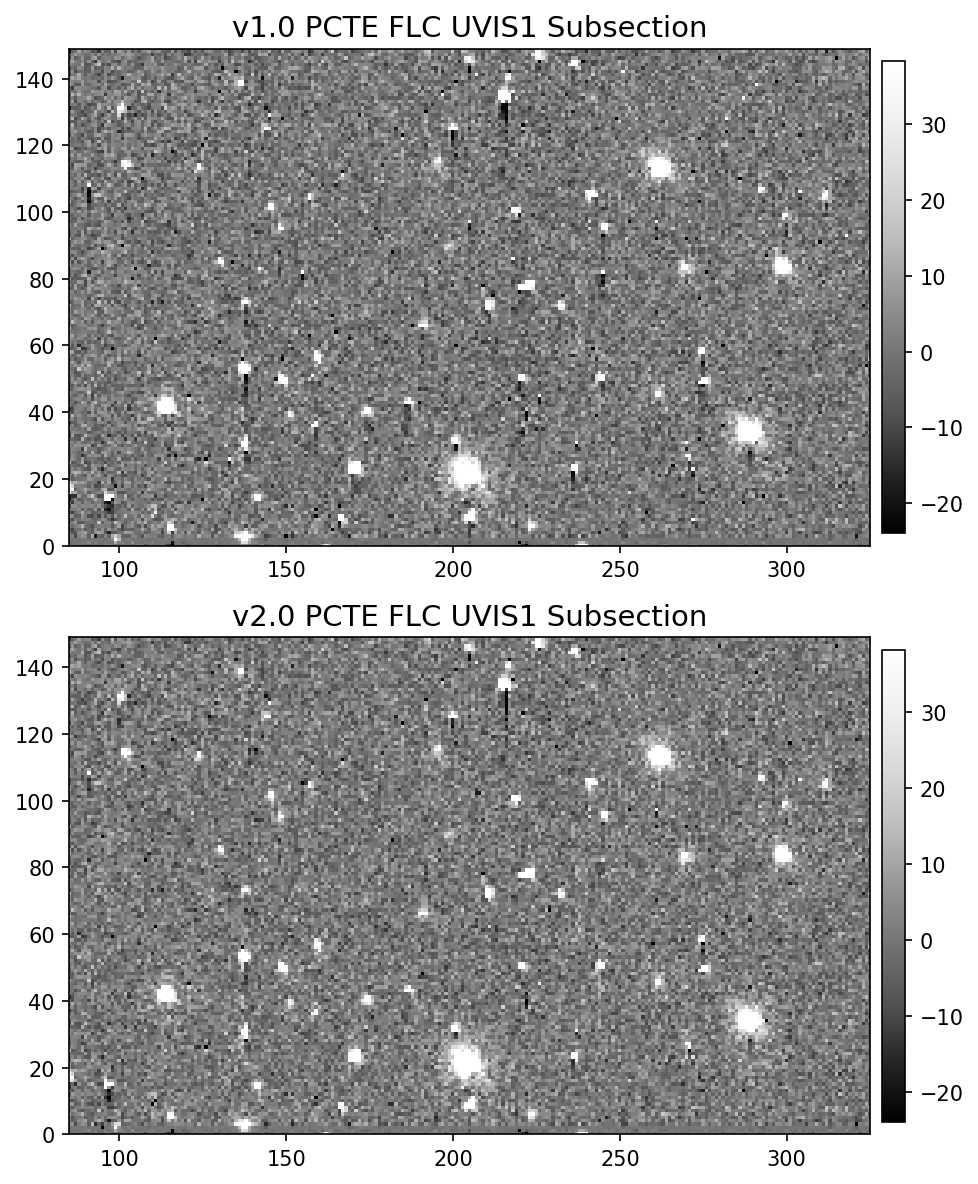

In [24]:
# Generate subplots
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 8), dpi=150)

# Calculate min and max values for image scaling 
z = ZScaleInterval()
z1, z2 = z.get_limits(v1_uvis1)

# Display subsection
im1 = ax1.imshow(v1_uvis1, origin='lower', cmap='Greys_r', vmin=z1, vmax=z2)
im2 = ax2.imshow(v2_uvis1, origin='lower', cmap='Greys_r', vmin=z1, vmax=z2)

# Formatting
ax1.set_xlim(85, 325), ax2.set_xlim(85, 325)
ax1.set_ylim(0, 149), ax2.set_ylim(0, 149)
fig.colorbar(im1, ax=ax1, shrink=0.95, pad=0.01)
fig.colorbar(im2, ax=ax2, shrink=0.95, pad=0.01)
ax1.set_title('v1.0 PCTE FLC UVIS1 Subsection', size=14)
ax2.set_title('v2.0 PCTE FLC UVIS1 Subsection', size=14)
fig.tight_layout()

<div style="text-align: left"> <strong> <font size ="4">Animated GIF of the v1.0 and v2.0 FLC image subsections: </font> </strong> </div>

<img align="left" width="975" src="example/v1_v2_subsection.gif" title="An animated GIF of the v1.0 and v2.0 FLC image subsections" alt="An animated GIF of the v1.0 and v2.0 FLC image subsections">

<a id="apphot"></a>
## 11.5 Aperture Photometry 
To show the quantitative difference in the observed flux of sources between the v1.0 and v2.0 pixel-based CTE correction,<br> we perform aperture photometry on six stars of varying brightness within the image subsection above. Here, we display the <br> image subsection again with the apertures, annuli, and star labels overplotted. This subsection includes the first ~150 rows <br> of UVIS 1, which means all of these stars suffer the most CTE flux loss as they transfer 1900+ rows to the readout amplifier.   

<img align="left" width="900" src="example/apphot_image.png" title="Aperture photometry illustration" alt="Aperture photometry illustration">

First, we approximate the center x and y positions of the stars in the 4Kx4K science arrays, and create the apertures and <br> annuli using `photutils`. <br>

Then, we use `photutils` to measure the signal in each area and subtract the background values in the annuli from the <br>aperture sum values. We define a function named `get_flux()` to do this for us.

In [25]:
def get_flux(data, aperture, annulus_aperture):
    """
    Function to calculate background subtracted aperture sum 
    
    Parameters:
    -----------
    data : float array
        The 2d array of science pixels being measured
    aperture : photutils obj
        A photutils aperture object with defined position and radius
    annulus_aperture : photutils obj
        A photutils circular annulus aperture object with defined position and radii
        
    Return:
    -------
    flux : float
        The measured background subtracted aperture sum 
    """
    
    # Generate photutils.aperture_photometry table object
    phot = aperture_photometry(data, aperture)
    
    # Measure background around sources. aperture_stats_tbl() comes from background_median.py
    bkg_phot = aperture_stats_tbl(data, annulus_aperture, method='exact', sigma_clip=True)
    
    # Calculate background subtracted aperture sum
    flux = phot['aperture_sum'] - bkg_phot['aperture_median'] * aperture.area
    
    return flux


# Approximate x,y pixel locations of each star in the 4Kx4K array
positions = [(299.4, 2135.6),
             (114.7, 2093.4),
             (171.3, 2074.9),
             (262.6, 2164.9),
             (289.1, 2085.6),
             (204.8, 2073.1)]

# Photutils cirular aperture object with small radius
aperture = CircularAperture(positions, r=3)

# Photutils circular annulus aperture object 
annulus_aperture = CircularAnnulus(positions, r_in=13, r_out=19)

# Call function to calculate flux of stars
# THE RUNTIME WARNING MAY BE IGNORED
fltflux = get_flux(fltsci, aperture, annulus_aperture)
v1flux = get_flux(v1sci, aperture, annulus_aperture)
v2flux = get_flux(v2sci, aperture, annulus_aperture)

/home/runner/work/hst_notebooks/hst_notebooks/notebooks/WFC3/calwf3_v1.0_cte/example/background_median.py:88: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
/home/runner/work/hst_notebooks/hst_notebooks/notebooks/WFC3/calwf3_v1.0_cte/example/background_median.py:88: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
/home/runner/work/hst_notebooks/hst_notebooks/notebooks/WFC3/calwf3_v1.0_cte/example/background_median.py:88: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


<div class="alert alert-block alert-warning" style="color:black" > <b> You can ignore the <code>RuntimeWarning: invalid value encountered in true_divide</code> message.</b> <br> </div>
    

Finally, we plot our results.<br>

The first plot below shows the measured flux of the six stars in each of the different calibrated products. Stars 1-6 are organized <br> by increasing flux, with Star 1 being the faintest and Star 6 being the brightest. The x-axis values correspond to the median flux <br> value measured in each of the three different files (FLT, v1.0, and v2.0) per star. The y-axis values show the individual flux values <br> for each star where the different colors and symbols represent the three file types. For example, the individual flux values (y-axis) <br> of Star 1 for the FLT, v1.0, and v2.0 files are ~2467, 3056, and 2799 e- respectively. The median of the three values is ~2799 e-, <br> which is the value plotted on the x-axis. The second plot illustrates the percent differences between the three different <br> flux values per star, and uses the same x-axis values as the first plot. <br> 

The FLT files have no CTE correction applied and thus have the lowest measured flux for each star due to the CTE flux loss. <br> Stars 1-4 have noticably different flux values between the v1.0 and v2.0 CTE corrections. In v1.0, the CTE algorithm is actually <br> over-correcting these fainter sources resulting in higher aperture photometry measurements. The flux values for stars 1-4 range <br> from  ~3000 - 10000 e- within a 3-pixel radius aperture. The flux values between the v1.0 and v2.0 CTE corrections for stars <br> 1-4 have percent differences of ~9 - 4%. Sources with more than ~10000 e- within a 3-pixel aperture (stars 5 & 6) have more <br> compareable flux values between the v1.0 and v2.0 CTE corrections, and have percent differences less than 2%.

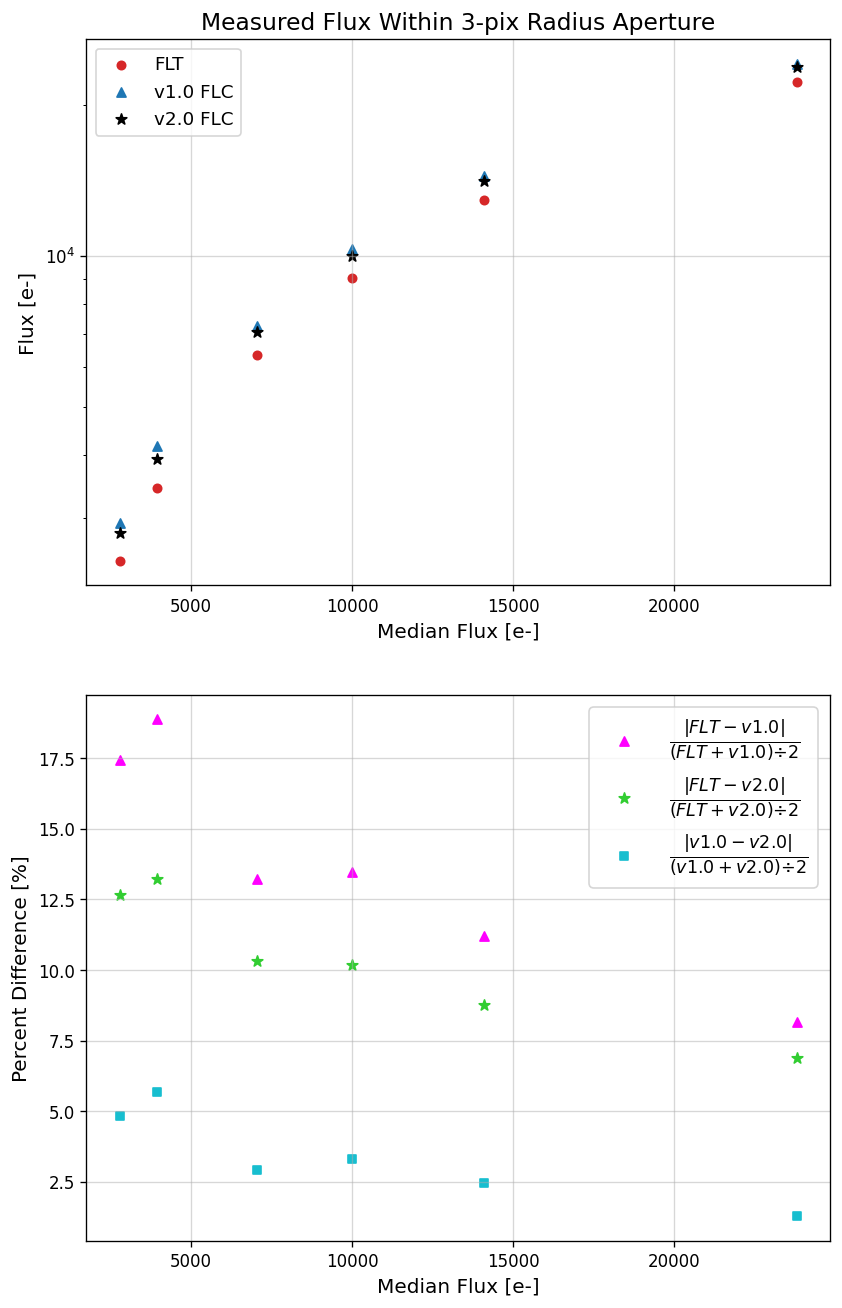

In [26]:
# Generate subplots
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 13), dpi=120)
ax1.grid(alpha=0.5), ax2.grid(alpha=0.5)

# Find median flux values between products
medflux = np.median([fltflux, v1flux, v2flux], axis=0)

# Scatter plot of measured flux
ax1.scatter(medflux, fltflux, 25, marker='o', c='C3', label='FLT')
ax1.scatter(medflux, v1flux, 30, marker='^', c='C0', label='v1.0 FLC')
ax1.scatter(medflux, v2flux, 45, marker='*', c='k', label='v2.0 FLC')

# Scatter plot of percentage difference
ax2.scatter(medflux, abs((fltflux-v1flux))/((fltflux+v1flux)/2)*100, 30,
            marker='^', c='magenta', label=r'$\frac{|FLT - v1.0|}{(FLT + v1.0) ÷ 2}$')
ax2.scatter(medflux, abs((fltflux-v2flux))/((fltflux+v2flux)/2)*100, 45,
            marker='*', c='limegreen', label=r'$\frac{|FLT - v2.0|}{(FLT + v2.0) ÷ 2}$')
ax2.scatter(medflux, abs((v1flux-v2flux))/((v1flux+v2flux)/2)*100, 25,
            marker='s', c='C9', label=r'$\frac{|v1.0 - v2.0|}{(v1.0 + v2.0) ÷ 2}$')

# Formatting 
ax1.set_title('Measured Flux Within 3-pix Radius Aperture', size=14)
ax1.set_xlabel('Median Flux [e-]', size=12)
ax1.set_ylabel('Flux [e-]', size=12)
ax2.set_xlabel('Median Flux [e-]', size=12)
ax2.set_ylabel('Percent Difference [%]', size=12)
ax1.legend(prop={'size': 11}), ax2.legend(prop={'size': 15})
ax1.set_yscale('log')

<a id="conclude"></a>
## 12. Conclusions

Thank you for walking through this notebook. You now have everything you need to process your own files with the v1.0 CTE <br>correction within `calwf3`. Since completing this notebook you should be more familiar with:

- Applying the v1.0 pixel-based CTE correction to 2009-2021 UVIS data.
- Which header keywords of the `raw` fits file to edit in order to use the v1.0 correction.
- How to find and download the appropriate `PCTETAB` and `DRKCFILE` reference files.
- Verifying your version of `calwf3` and calibrating a `raw` file with the v1.0 CTE correction.
- Investigating the differences between v1.0 and v2.0 CTE corrected files.

### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please feel free to contact the [WFC3 Helpdesk](https://stsci.service-now.com/hst) for any questions.

- [WFC3 CTE Website](https://www.stsci.edu/hst/instrumentation/wfc3/performance/cte)
- [HSTCAL GitHub](https://github.com/spacetelescope/hstcal)
- [Calwf3 Documentation](https://wfc3tools.readthedocs.io/en/latest/wfc3tools/calwf3.html)
- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
- [STScI Jupyter-notebooks](https://github.com/spacetelescope/hst_notebooks)
- [HSTCAL on Conda-Forge](https://anaconda.org/conda-forge/hstcal/files?version=2.6.0)

<a id="about"></a>
## About this Notebook

**Author:** Benjamin Kuhn; WFC3 Instrument Team <br>
**Created:** February 22, 2022 <br>
**Last updated on:** October 30, 2025

<a id="cite"></a>
## Citations

If you use `astropy`, `astroquery`, `numpy`, `matplotlib`, `photutils`, or `scipy` for published research, please cite the authors.<br>
Follow these links for more information about citing the libraries below:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `photutils`](https://photutils.readthedocs.io/en/stable/getting_started/citation.html)
* [Citing `scipy`](https://scipy.org/citing-scipy/)
<br>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 